# topic modeling pipeline

This notebook will walk you through:
1. data reterival from SQL database
2. Pre-processing data
3. Running topic modeling (different models)
4. post processing (including showing topics, topic-doc distribution, etc.)
5. Storing results into DB

# imports

In [1]:
from pre_processing import remove_html_tags, preprocess_data, prepare_corpus
from post_processing import topic_selection
from rpy2 import robjects #loading R inside Python
#importing functions to read pandas DF
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

import pandas as pd

import numpy as np

import os

#import R base library
base = importr('base')

mallet_path = 'mallet' #'mallet for mac-os

[nltk_data] Downloading package stopwords to /Users/das-
[nltk_data]     lab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/das-lab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/das-lab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/das-lab/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


loading stop words

In [2]:
#downloading github repo for down-sampling==> you only need this once!
# !git clone https://github.com/aminmarani/authorless-tms.git

In [3]:
stop_words = []

with open('freqPOS+Names.stop','r') as txtfile:
    for r in txtfile:
        stop_words.append(r.strip())
        if "'" in r:#add the term without "'"; e.g., haven't & havent
            stop_words.append(r.replace("'","").strip())

#adding the selected stop_words
stop_words.extend(['go', 'day', 'eat', 'ed'])

stop_words[10:15]

['duncan', 'fluffy', 'jack', 'jake', 'jim']

# Loading data from SQL database

First creating a connection

**In order to create a connection from anywhere in LU network you need to run the command below in terminal. Replace your username with amh418 in the command below.**

ssh -L 3306:127.0.0.1:3306 -N -f amh418@128.180.111.76   #it will ask for lehigh pass

on network (128.180.111.76)
outside the network (ssh.lehigh.edu)

**if you need to kill to SSH forwarding use the link below**

https://superuser.com/questions/87014/how-do-i-remove-an-ssh-forwarded-port


In [4]:
import mysql.connector

#connecting to DB
cnx = mysql.connector.connect(user='push', password='ElI)g!LDOBIwM)%*5o5{dbfz('
                              ,host='127.0.0.1',database='edml')

Retreiving all the posts

**We are exlcuding recoverwithmeda for now**

In [5]:
cursor = cnx.cursor() #making a cursor to execute a SQL command
# cursor.execute("select * from post") #execute a command
cursor.execute("select * from post where user_id != (select user_id from user where user_login='recoverwithmeda')") #execute a command
myresult = cursor.fetchall() #get all the results 
print('{0} posts were retreived'.format(len(myresult))) 

8341 posts were retreived


In [6]:
#loading user_id and user_name to convert id to user_name
cursor.execute("select * from user") #execute a command
users = cursor.fetchall() #get all the results 
users = {i[0]:i[1] for i in users}
myresult = [i[0:2] + tuple([users[i[2]]]) + i[3:] for i in myresult]

In [7]:
#concatenating the old dataset to the new one
myresult_ = [tuple(i[1:]) for i in pd.read_csv('./data/old_ed.csv',index_col=None).values]
myresult += myresult_
print('{0} posts were retreived'.format(len(myresult))) 

21338 posts were retreived


showing couple of samples

In [8]:
idx = np.random.choice(np.arange(len(myresult)),5,replace=False)
[myresult[i] for i in idx]

[(10923,
  5,
  'veganhollyg',
  'The decision has been made . . . WE’RE STAYING IN GERMANY 🙈🤩\n-\nThis is definitely the most spontaneous decision I’ve made (in my life 😳😅), and that’s why I let you make the final call!!! 94% said to stay by midnight, so the cancellations have been made and I’m not going home for another week 🙃🤓\n-\nNow I also say I’m staying in Germany, but we might actually get to a different country (or two?!) over the next seven days and I’m actually buzzzzzzing 👌🏻😆\n-\nAs I said on my story, #hollygoessolo has become #hollygoestrio . . . and I blame Charlie and Daniel. Nothing else needs to be said 😅🙃\n-\nALLONS-YYYYYYYYYY (yes that is French 😂) 👏🏻🌎',
  datetime.datetime(2022, 7, 31, 16, 8, 8),
  'https://www.instagram.com/p/CgrstrRtZvE/',
  None,
  None,
  None,
  None,
  None,
  None),
 (527,
  4,
  'mirithebrave',
  '\n \n honeyyvanille: \n\n Sometimes you need to remind yourself that you were the one who carried you through the heartache. You are the one who 

Language detection

keeping only English language posts/documents

In [9]:
from langdetect import detect
from tqdm import tqdm


# myresult = [s for s in myresult if len(remove_html_tags(s[3])) > 3 and detect(remove_html_tags(s[3]))=='en']
t = []
#removing tags and detecting language afterward
for s in tqdm(myresult):
    try:#in some case language detection may fail (emojies only, one word docs, etc.) ==> We don't keep those
        if detect(remove_html_tags(s[3]))=='en':
            t.append(s)
    except:
        pass #do nothing

myresult = t[:]
print('after removing non-english posts,the size of the documents are: {0}'.format(len(myresult)))

100%|████████████████████████████████████| 21338/21338 [02:52<00:00, 123.69it/s]

after removing non-english posts,the size of the documents are: 17321


# preprocessing the data

First, removing html tags

prepare the corupus

In [10]:
#removing tags from texts
proc_texts = [remove_html_tags(i[3]) for i in myresult]
#pre_processing and tokenizing docs
pre_processed_docs,orig_docs = preprocess_data(proc_texts,extra_stopwords=stop_words)
#attaching (id,original_text,pre_processed_text,date,url) together
id_text = [(myresult[orig_docs[i][1]][0],orig_docs[i][0],pre_processed_docs[i],
            myresult[orig_docs[i][1]][4],myresult[orig_docs[i][1]][5],
            myresult[orig_docs[i][1]][2]) for i in range(len(orig_docs))]

# vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs) ==> we don't need prepare corpus as we are passing this to LDA and STM R and there they will do tokenization 

#creat a pandas DF with one column as text, one column as original text, one column as SQL post-id, etc.
text_df = pd.DataFrame(zip([i[0] for i in id_text],[' '.join(i[2]) for i in id_text],
                           [i[1] for i in id_text],[i[3] for i in id_text],[i[4] for i in id_text],
                          [i[5] for i in id_text]),
                       columns=['id','text','original_text','date','url','blog'])

In [11]:
#removing duplicates only if necessary
print(len(text_df))
text_df = text_df.drop_duplicates(subset=['text'])
print(len(text_df))

14297
13588


# Term Frequency

Term frequency and Term/doc frequency

In [12]:
import collections

#extracting uni-grams
terms = []
for s in list(text_df.text):
    terms.extend(s.split())

#computing frequency of each term
freqs = collections.Counter(terms)
sorted(freqs.items(),key= lambda x:x[1],reverse=True )[0:100]
# freqs

[('time', 4549),
 ('feel', 4329),
 ('get', 3913),
 ('body', 3655),
 ('life', 3497),
 ('eating', 3455),
 ('really', 3133),
 ('good', 3109),
 ('food', 3004),
 ('want', 2967),
 ('love', 2831),
 ('things', 2749),
 ('people', 2716),
 ('even', 2662),
 ('going', 2505),
 ('way', 2476),
 ('today', 2471),
 ('cup', 2433),
 ('back', 2353),
 ('need', 2234),
 ('still', 2225),
 ('see', 2199),
 ('week', 2075),
 ('always', 1936),
 ('let', 1865),
 ('never', 1721),
 ('right', 1703),
 ('chocolate', 1701),
 ('got', 1676),
 ('new', 1620),
 ('question', 1607),
 ('take', 1600),
 ('work', 1568),
 ('answer', 1552),
 ('last', 1529),
 ('recovery', 1517),
 ('happy', 1506),
 ('best', 1482),
 ('lot', 1476),
 ('first', 1475),
 ('feeling', 1455),
 ('days', 1420),
 ('weight', 1407),
 ('add', 1400),
 ('hope', 1398),
 ('thing', 1394),
 ('bowl', 1386),
 ('hard', 1384),
 ('better', 1348),
 ('help', 1338),
 ('little', 1312),
 ('look', 1300),
 ('trying', 1292),
 ('self', 1288),
 ('keep', 1260),
 ('home', 1254),
 ('minutes', 

In [15]:
#terms-document proportion
term_doc = {k:0 for k,v in freqs.items() if v>len(text_df)*0.05}

#compute term_doc
for s in list(text_df.text):
    for k in term_doc.keys():
        if k in s.split():
            term_doc[k]+=1

In [23]:
#terms that appear in 20% or more of documents
candids = {k:v for k,v in term_doc.items() if v>=len(text_df)*0.15}
selected_stop_words = set(candids.keys())
selected_stop_words
# candids

{'feel', 'get', 'good', 'life', 'really', 'time'}

# Blog distribution

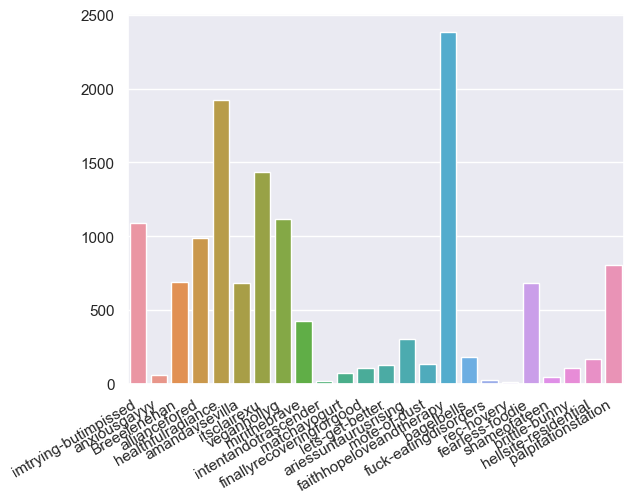

In [283]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

blog_dist = Counter(list(text_df.blog))
sns.barplot(x=list(blog_dist.keys()),y=list(blog_dist.values()))
a = plt.xticks(rotation=30,ha='right') 
# list(blog_dist.values())

In [10]:
# list(text_df[text_df.blog=='faithhopeloveandtherapy'].sample(frac=0.2).head(20).url)

Processing documens for Topicalizer

In [7]:
# text_df[['date','original_text','url']].rename(columns={'original_text':'entry','url':'Link'}).to_csv('./data/processed_ed.csv')

# Author down-sampling

down-sampling terms that are more specific to an author

In [95]:
# vocab = set()

# for tx in list(text_df.text):
#     tokens = tx.split()
#     [vocab.add(t) for t in tokens]

# with open('./data/temp_vocab_corpus.txt','w') as tfile:
#     tfile.writelines([i+'\n' for i in list(vocab)])

# print('size of dictionary is {0}'.format(len(vocab)))

size of dictionary is 33109


In [96]:
# #storing corpus for down-sampling (we send the pre-processed docs)
# text_df[['blog','text']].to_csv('./data/temp_documents_corpus.txt',index=True,sep='\t',
#                                 header=False,encoding="UTF-8")

In [97]:
# #running down-sampling ==> if the original file in repo pops error you need to make changes in the downsample_corpus.py as stated below
# #line 68: term_means = np.mean(author_term_freqs, axis=0).ravel() 
# #line 71: term_vars = np.var(author_term_freqs, axis=0, ddof=1).ravel()
# #line 83: author_term_freqs = author_term_freqs.toarray()#added 2023,Nov
# #line 88: author_freqs = author_term_freqs[:, term_id].ravel()#.getA1() #added 2023,Nov
# !python3 ./authorless-tms/downsample_corpus.py --input ./data/temp_documents_corpus.txt --output ./data/temp_documents_corpus_new003.txt --vocab ./data/temp_vocab_corpus.txt --threshold 0.03

Building doc-term matrix
Building author-term matrix
Building stop weights
Downsampling file


# loading from down-sampled dataset

In [45]:
# #updating text_df
# new_df = pd.read_csv('./data/temp_documents_corpus_new005.txt',sep='\t',header=None,
#                      names=['id','blog','text'])

# #replacing down-sampled data with original data
# for id,row in tqdm(new_df.iterrows()):
#     text_df.loc[text_df.id==id,'text'] = row['text']
#     # text_df.at[int(id),'text'] = row['text']

# #removing the ones that were deleted during down-sampling
# text_df = text_df[text_df.id.isin(new_df.id)]

# print('Number of documents after down-sampling: {0}'.format(len(text_df)))

8629it [00:04, 1991.88it/s]

Number of documents after down-sampling: 8171


# Running topic modeling (with or without evaluation)

In [8]:
# from rpy2.robjects.packages import importr
# utils = importr('utils')

# utils.install_packages('stm',repos="https://cloud.r-project.org")

In [ ]:
is_eval = True #not evaluating the model
lon,upn = 5,30 #lowwer and upper topic number for evaluation
#need to provide number of topics and other specification
model_spec = {'name':'LDA','K':21,'epochs':2000,'burnin_iteration':20,'after_iteration_burnin':50,
             'save_flag':True,'save_path':'LDA_test'}
# model_spec = {'name':'STM','K':90,'epochs':500,'prevalence':'','content':'','pre_trained_model': 'LDA',\
#                 'burnin_iteration':20,'LDA_epochs':50,'save_flag':True}

if model_spec['name'] == 'LDA':
    if is_eval:
        #loading LDA mallet evaluation score
        from lda_mallet import lda_score
        from gensim.corpora import Dictionary
        import pickle
        from pre_processing import prepare_corpus
        #creating data vocab
        dict = Dictionary([i.split() for i in list(text_df.text)])
        #saving it to pass it to score object
        with open ('./data/ED_vocab.obj','wb') as vfile:
            pickle.dump(dict,vfile)
        wiki_vocab_dict_path = './data/wiki_sampled5p_vocab.obj'
        with open ('./data/wiki_sampled5p_vocab.obj','rb') as vfile:
            wiki_vocab_dict = pickle.load(vfile)


        npmis = []
        for n_topics in range(lon,upn,1):
            #removing terms that are not in the Wiki Vocab
            #pre_processing and tokenizing docs
            # pre_processed_docs,_ = preprocess_data(list(text_df.text),extra_stopwords=\
            #                                                set(dict.values()).difference(set(wiki_vocab_dict.values()))\
            #                                        .union(['denying']))
            pre_processed_docs,_ = preprocess_data(list(text_df.text),extra_stopwords=\
                                                  selected_stop_words)
            #preparing corpus
            vocab_dict,doc_term_mat = prepare_corpus(pre_processed_docs)
            #temp save of vocab file
            with open ('./data/ED_vocab.tmp','wb') as vfile:
                pickle.dump(vocab_dict,vfile)
            
            scorer = lda_score(num_topics=n_topics,alpha=10,optimize_interval=10,iterations=2000,wiki_path='./data/wiki_sampled_5p.txt',
                      db_path = './data/wiki_full/',vocab_dict_path = './data/ED_vocab.tmp', 
                      wiki_vocab_dict_path=wiki_vocab_dict_path,npmi_skip_threshold=0.30)
            
            scorer.fit(doc_term_mat)#fitting an LDA Mallet
            npmis.append([n_topics,scorer.score()])
    else: 
        #removing previously created mallet_file
        try:
            os.remove('MalletInstance_ {0}'.format(model_spec['save_path'])) 
            os.remove('MalletState_ {0} .gz'.format(model_spec['save_path']))
            os.remove('MalletSpec_ {0}'.format(model_spec['save_path']))
        except:#in case we don't have any files
            pass
        robjects.r.source('LDA_R.R')
        copy_text_df = text_df.copy()
        ans = robjects.r.findTopics(docs = copy_text_df,n_topics = model_spec['K'],epochs = model_spec['epochs'],
                                    burnin_iteration = model_spec['burnin_iteration'],
                                    after_iteration_burnin =  model_spec['after_iteration_burnin'],
                                    save_flag=model_spec['save_flag'],save_path = model_spec['save_path'])
        top_terms = np.asarray(ans[1])
        topic_doc_dist = np.asarray(ans[0][0]).T
        term_probab = ans[0][1]
        topic_vocab = ans[0][2]
        
        
elif model_spec['name'] == 'STM':
    if is_eval:
        pass
    else: 
        robjects.r.source('stm.R')
        ans = robjects.r.run_stm(docs = text_df,topic_n=model_spec['K'],max_itr=model_spec['epochs'],
                                 prevalence=model_spec['prevalence'],content=model_spec['content'],
                                 model_type = model_spec['pre_trained_model'],
                                 nits = model_spec['LDA_epochs'],burnin = model_spec['burnin_iteration'],
                                 save_flag = True)
        top_terms = np.asarray(ans[1]).reshape(model_spec['K'],50,order='F')
        topic_doc_dist = 0.00

Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 832
total tokens: 565545
<10> LL/token: -8.48088
<20> LL/token: -8.1969
<30> LL/token: -8.11922
<40> LL/token: -8.0867

0	2	question answer back therapy school baby shit long hard friends family therapist fucking bit nice people home parents bc lot 
1	2	today food happy week love home morning full days guys meal fun night friends year meals big super yesterday weekend 
2	2	eating people recovery love disorder support care work world health share hope mental disorders give free proud calories post alliance 
3	2	cup chocolate add bowl #healthy butter #glutenfree #healthyfood #foodie #foodblogger #healthyinspo tbsp #healthylife minutes #healthymeals salt #plantpower #fitness #wellness powder 
4	2	body things food weight feeling healthy eating lot thing mind thought felt years real session thoughts love change bad week 

<50> LL/token: -8.06894
<60> LL/token: -8.05532
<70> LL/token: -8.04639
<80> LL/token: -8.04024

<Axes: xlabel='n_topics', ylabel='npmi_average'>

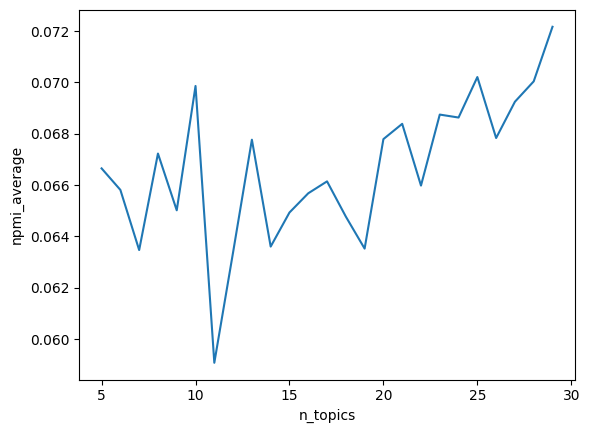

In [31]:
#new and old dataset with downsampling .20
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

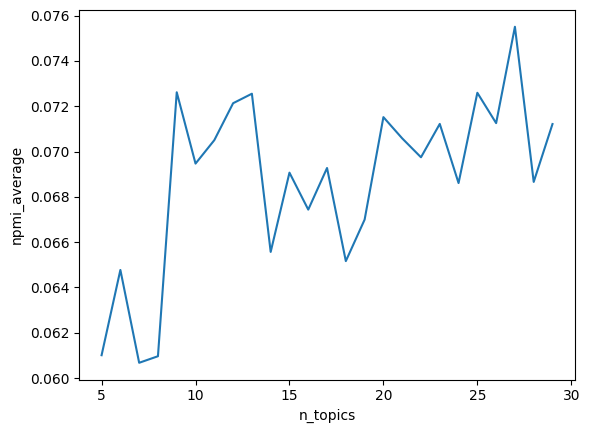

In [29]:
#new and old dataset with downsampling .15
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

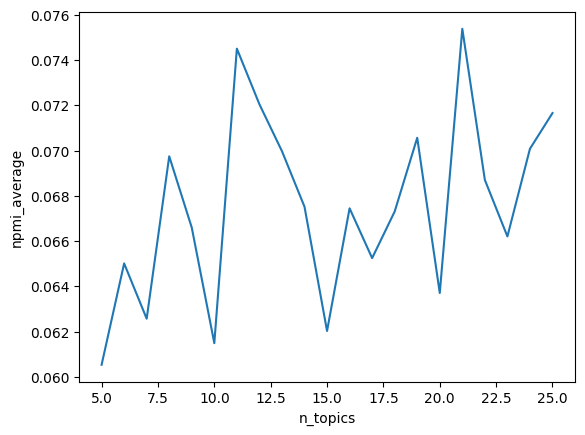

In [15]:
#new and old dataset with downsampling .10
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

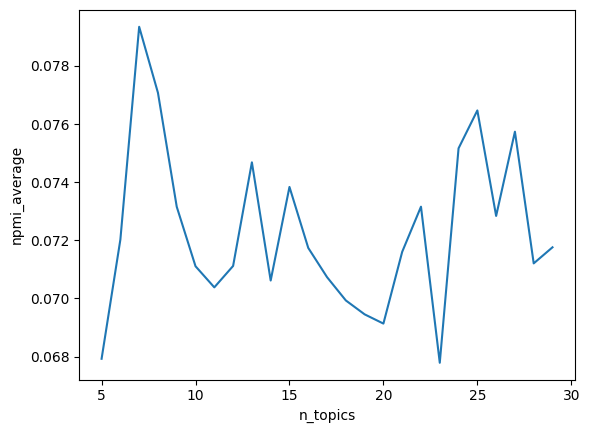

In [14]:
#new and old dataset with downsampling .05 - longer version
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

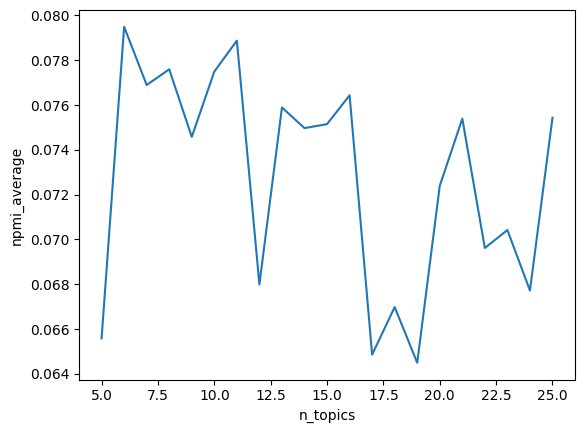

In [98]:
#new and old dataset with downsampling .05
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

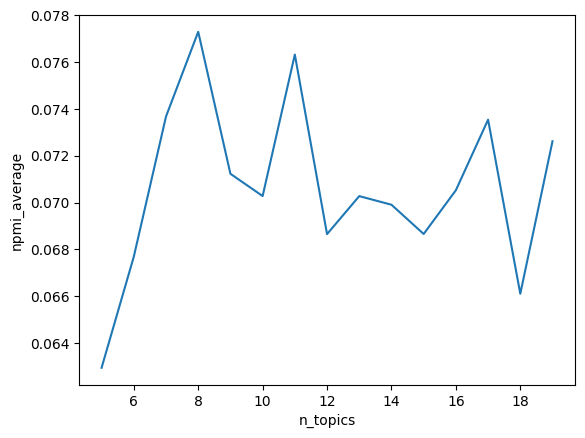

In [16]:
#new and old dataset
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

<Axes: xlabel='n_topics', ylabel='npmi_average'>

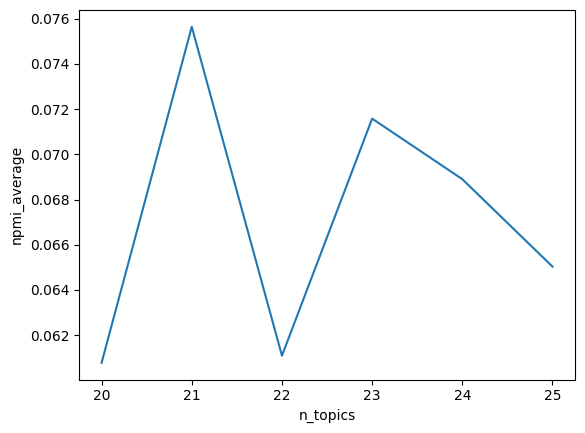

In [18]:
#new dataset
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

# Post-processing

topic distribution and topic selection

for topic selection I used elbow method (selecting top topics till we get to the highest gap)

In [47]:
#topic selection
topics4docs,topics4docs_bin = topic_selection(topic_doc_dist)

#topic distribution addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_dist'.format(i)] = topic_doc_dist[:,i]
#topic selection addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_select'.format(i)] = topics4docs_bin[:,i]

#saving data to csv
text_df.to_csv('document_topic_info.csv')

In [48]:
#storing top terms
topic_df = pd.DataFrame(data=top_terms,columns=['top_terms'])
topic_df.to_csv('topic_terms.csv')

Running Coherence

In [49]:
from lda_mallet import lda_score
import pickle

# import importlib
# importlib.reload(scorer.score_per_topic(None))

#initiate scorer
scorer = lda_score(wiki_path='./data/wiki_sampled_5p.txt',db_path='./data/wiki_full/',npmi_skip_threshold=0.20)

'''
loading wikipedia vocab to 
    1. remove the top terms that are not in the wikipedia
    2. use for gensim.coherence vocab argument in case any pairs are not in the DB
'''
with open('./data/wiki_sampled5p_vocab.obj','rb') as f:
    scorer.wiki_vocab_dict = pickle.load(f)
    
#add all_top_terms (except the ones that are not in the wiki_pedia vocab)
scorer.all_top_terms = [[t for t in top_terms[i].split() if t in scorer.wiki_vocab_dict.token2id.keys()] for i in range(len(top_terms))]
#the output is a dictionary: the key is 0-n_topics and associated with npmi score for top-k topics 
#in which k=5,10,15,20
topic_scores = scorer.score_per_topic(None)
#getting avergae of multiple k for each topic
topic_score_avg = [np.mean([vi for ki,vi in v.items()]) for k,v in topic_scores.items()]

Load NPMI coherence DB. 
Number of keys : 1934666
skipping 0 missed term-pairs < allowed misses = 0.2


# soring top terms and top documents

In [50]:
show_top_doc = 10
show_top_terms = 10
file_name = 'top_documents_lda21_new_old_data_downsampled_05.txt'

#writing the results in a text file
with open(file_name,'w') as tfile:
    for i in range(len(top_terms)):
        #writing top terms
        tfile.write('Topic '+ str(i) + ' : '+'\n'+'top terms: '+', '.join(top_terms[i].split()[:show_top_terms])+'\n')
        #selecting top documents
        top_docs = text_df.sort_values('Topic{0}_dist'.format(i),ascending=False).iloc[0:show_top_doc,:]
        for _,row in top_docs.iterrows():
            tfile.write('Doc ID: {0}, distribution: {1} ; {2} \n'.format(row.id,row['Topic{0}_dist'.format(i)],row['original_text']))
            tfile.write(''.join(['-']*60)+'\n')
        

# Storing to DB

The process is described in the code cell below

**Used the link below to insert and load blob**

https://pynative.com/python-mysql-blob-insert-retrieve-file-image-as-a-blob-in-mysql/

In [15]:
#1. save model id (for LDA save as zip and then save)
'''
2. for each topic
    3. save topic
    4. retreive the saved topic_id and save r_topic_model
    5. for each doc save r_topic_post
'''
###table format
#model: model_id, data, model_type, last_used?
# topic: topic_id, coherence, term1-50, probab1-50
#r_topic_model: topic_id, model_id 
#r_topic_post: topic_id, post_id, proportion

##check the columns of a table
# cursor.execute("show columns from r_topic_post") #execute a command
# myresult = cursor.fetchall() #get all the results 
# myresult

'\n2. for each topic\n    3. save topic\n    4. retreive the saved topic_id and save r_topic_model\n    5. for each doc save r_topic_post\n'

In [69]:
#saving the model first
#model: model_id, data, model_type, last_used?
if model_spec['name'].lower() == 'lda':
    #read binary data of the saved model
    with open('MalletState_ '+model_spec['save_path']+' .gz','rb') as model_file:
        binary_data = model_file.read()
else:
    pass #write codes for other models

#storing the model
cursor.execute(" INSERT INTO model (data, model_type) VALUES (%s,%s)",
                    (binary_data,model_spec['name']))

In [70]:
#load the model with model id to use for next steps
cursor.execute("Select * from model ORDER BY model_id DESC LIMIT 1")
result = cursor.fetchall()
model_id,model_name = result[0][0],result[0][2]

In [71]:
#saving each topic separately alongside relation to model table and post table
for k in range(0,model_spec['K']):#iterating over each topic
    #getting topic top terms
    topic_top_terms = top_terms[k].split()
    #we have to find the index in vocab (ans[0][2]) and then call ans[0][1][k][found_index] to get
    #the probability of each term
    probab = [float(term_probab[k][i]) for w in topic_top_terms for i in range(len(topic_vocab)) if w == topic_vocab[i]]
    #adding coherence score, top terms and their probabilities
    vals = tuple([float(topic_score_avg[k])]) + tuple(topic_top_terms) + tuple(probab)
    #save each topic seperately
    cursor.execute(" INSERT INTO topic(coherence,{0},{1}) VALUES (%s,{2})".format(
                                        ','.join(['term'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['prob'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['%s']*(len(topic_top_terms)*2))),vals)
    
    '''
    retreiving saved topic_id and save an entry for topic_id,model_id in topic_model_r table
    '''
    #load the latest stored topic
    cursor.execute("Select * from topic ORDER BY topic_id DESC LIMIT 1")
    result = cursor.fetchall()
    topic_id = result[0][0]
    #save the topic_id,model_id in r_topic_model table 
    cursor.execute(" INSERT INTO r_topic_model(topic_id,model_id) VALUES (%s,%s)",
                  (topic_id,model_id,))
    
    '''
    saving topic-document proportion for each topic-doc pairs
    '''
    #r_topic_post : topic_id, post_id, proportion
    doc_counter = 0
    for doc_id in list(text_df.id):
        cursor.execute(" INSERT INTO r_topic_post(topic_id,post_id,proportion) VALUES (%s,%s,%s)",
                  (topic_id,doc_id,float(topic_doc_dist[doc_counter,k])))
        doc_counter += 1
        

In [72]:
cnx.commit()

In [21]:
# cursor.execute("delete from r_topic_model")
# cursor.execute("delete from r_topic_post")
# cursor.execute("delete from topic")
# cursor.execute("delete from model")

# cursor.execute("select * from post")
# cursor.execute("SELECT DISTINCT user.* FROM user JOIN post ON user.user_id = post.user_id WHERE post.platform_type_id = %s",('4',))
# cursor.execute("SELECT * FROM post WHERE user_id = %s AND created BETWEEN %s AND %s;",(3,'1/1/2023','1/1/2013',))
# cursor.execute("SELECT r_topic_post.topic_id, AVG(r_topic_post.proportion) as average_proportion FROM r_topic_post JOIN r_topic_model ON r_topic_post.topic_id = r_topic_model.topic_id WHERE r_topic_post.post_id = %s AND r_topic_model.model_id = %s GROUP BY r_topic_post.topic_id;",('1187','2',))
# cursor.execute('select * from model')
cursor.fetchall()

[(11, Decimal('0.005300000')),
 (12, Decimal('0.223030000')),
 (13, Decimal('0.002400000')),
 (14, Decimal('0.007130000')),
 (15, Decimal('0.005350000')),
 (16, Decimal('0.012220000')),
 (17, Decimal('0.006210000')),
 (18, Decimal('0.005680000')),
 (19, Decimal('0.004940000')),
 (20, Decimal('0.727740000'))]

# Post-processing for Author-topic distribution

**if you are reading from DB set the from_db= True**

In [51]:
from_db = False

In [52]:
if not from_db:
    topics = [[i,topic_score_avg[i],'_'.join(top_terms[i].split()[0:3])] \
              for i in range(len(top_terms))]
else:
    #taking last topics 
    cursor.execute("select * from topic")
    topics = [list(i[0:2]) + ['_'.join(i[2:6])] for i in cursor.fetchall()[-7:]] #each topic include topic_id, coherence_score and top three terms

In [53]:
topics

[[0, -10.13355582988363, 'cheese_sauce_bowl'],
 [1, -0.7328988440525172, 'eating_recovery_disorder'],
 [2, -71.03605598124956, 'white_people_tree'],
 [3, -0.19687601252509135, 'cream_ice_coffee'],
 [4, -0.43035285822745256, 'day_time_today'],
 [5, -23.20821033790054, 'hair_yoga_take'],
 [6, -20.1836637569796, 'get_people_feel'],
 [7, -7.188093114527588, 'cup_chocolate_butter'],
 [8, 0.0413132247725217, 'time_guys_day'],
 [9, -28.447491069353426, 'run_running_training'],
 [10, -1.254150120889438, 'life_love_want'],
 [11, -1.3253049564108375, 'vegan_plant_based'],
 [12, 0.05578500254755439, 'day_today_time'],
 [13, 0.08335692596637344, 'life_feel_things'],
 [14, -4.725263272917867, 'years_life_disorder'],
 [15, -6.440907959667727, 'body_weight_look'],
 [16, -49.82879536010924, 'people_question_family'],
 [17, -18.236249219134887, 'feel_really_time'],
 [18, 0.11935825491651139, 'oats_protein_butter'],
 [19, -2.9724276347237195, 'holiday_giveaway_christmas'],
 [20, -0.0925133982585544, 'fo

In [54]:
#taking post_topics
if from_db:
    cursor.execute("select * from r_topic_post where topic_id between {0} and {1}".format(min(topics)[0],max(topics)[0]))
    res = cursor.fetchall() #topic_id, document_id, topic_dist
    
    doc_dist = {}
    
    for item in res:
        if item[1] not in doc_dist.keys():
            doc_dist[item[1]] = {}
        doc_dist[item[1]][item[0]] = item[2]
else:
    doc_dist = text_df.iloc[:,6:6+len(topics)].values.copy().T#topic_doc_dist.copy().T

In [55]:
#clipping doc_dist and converting to pandas DF as well
from tqdm import tqdm
from similarity import picking_topic

ddist_df = pd.DataFrame(doc_dist).T

ddist_np = ddist_df.values

for i in tqdm(range(ddist_np.shape[0])):
    ddist_np[i] = picking_topic(ddist_np[i].astype('float')) * ddist_np[i].astype('float')

100%|████████████████████████████████████| 8171/8171 [00:00<00:00, 12227.00it/s]


In [56]:
if from_db:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = ddist_df.index
    ddist_df = ddist_df.merge(text_df[['id','blog']],on='id')
else:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = list(text_df.id)
    ddist_df['blog'] = list(text_df.blog)

In [57]:
ddist_blog = ddist_df.groupby('blog').sum()
ddist_blog.iloc[:,0:-1] = ddist_blog.values[:,0:-1]/np.sum(ddist_blog.values[:,0:-1],axis=0)
ddist_blog

,cheese_sauce_bowl,eating_recovery_disorder,white_people_tree,cream_ice_coffee,day_time_today,hair_yoga_take,get_people_feel,cup_chocolate_butter,time_guys_day,run_running_training,...,day_today_time,life_feel_things,years_life_disorder,body_weight_look,people_question_family,feel_really_time,oats_protein_butter,holiday_giveaway_christmas,food_eating_eat,id
blog,,,,,,,,,,,,,,,,,,,,,
Breeelenehan,0.195826,0.001389,0.002670,0.013818,0.016200,0.012802,0.002704,0.103088,0.006069,0.000000,...,0.184161,0.024923,0.101320,0.005954,0.000000,0.004764,0.175217,0.023714,0.013947,1138596
alliancefored,0.017489,0.055294,0.167185,0.008269,0.192056,0.079561,0.091942,0.002215,0.016079,0.163103,...,0.032982,0.055655,0.182534,0.106163,0.246393,0.232000,0.002824,0.057512,0.136038,4276229
amandavsevilla,0.010226,0.002020,0.005960,0.021282,0.013515,0.122334,0.004292,0.002191,0.012215,0.018224,...,0.015466,0.034525,0.035809,0.017890,0.016258,0.013140,0.011522,0.018506,0.009920,1820703
anxiousgayyy,0.008429,0.000000,0.000000,0.005226,0.000936,0.000000,0.000000,0.014386,0.000000,0.000000,...,0.001211,0.002258,0.024472,0.003482,0.000000,0.000000,0.004535,0.000000,0.000000,50933
ariessuntaurusrising,0.054813,0.000000,0.000000,0.003364,0.000451,0.000000,0.000799,0.162279,0.000493,0.000000,...,0.004954,0.002830,0.012283,0.003338,0.000000,0.000788,0.017879,0.018020,0.000000,203232
bagelbells,0.011360,0.006164,0.048093,0.009970,0.038142,0.024873,0.014573,0.001156,0.026425,0.082902,...,0.013169,0.012658,0.032622,0.037845,0.030481,0.035514,0.020277,0.020881,0.034754,998165
brittle-bunny,0.001517,0.000000,0.000000,0.001596,0.025256,0.018733,0.014821,0.000000,0.000000,0.006224,...,0.001412,0.005375,0.003058,0.040839,0.001857,0.010086,0.000000,0.002048,0.031579,771437
faithhopeloveandtherapy,0.325498,0.026597,0.091919,0.195015,0.099739,0.214799,0.011816,0.175658,0.326598,0.113954,...,0.408310,0.398281,0.219452,0.197385,0.060418,0.048274,0.359568,0.224458,0.252127,7461408
fearless-foodie,0.006048,0.006001,0.132256,0.024313,0.115741,0.037471,0.053761,0.007939,0.008344,0.083221,...,0.014317,0.030719,0.044109,0.041293,0.169542,0.135707,0.001870,0.027179,0.026777,3028782


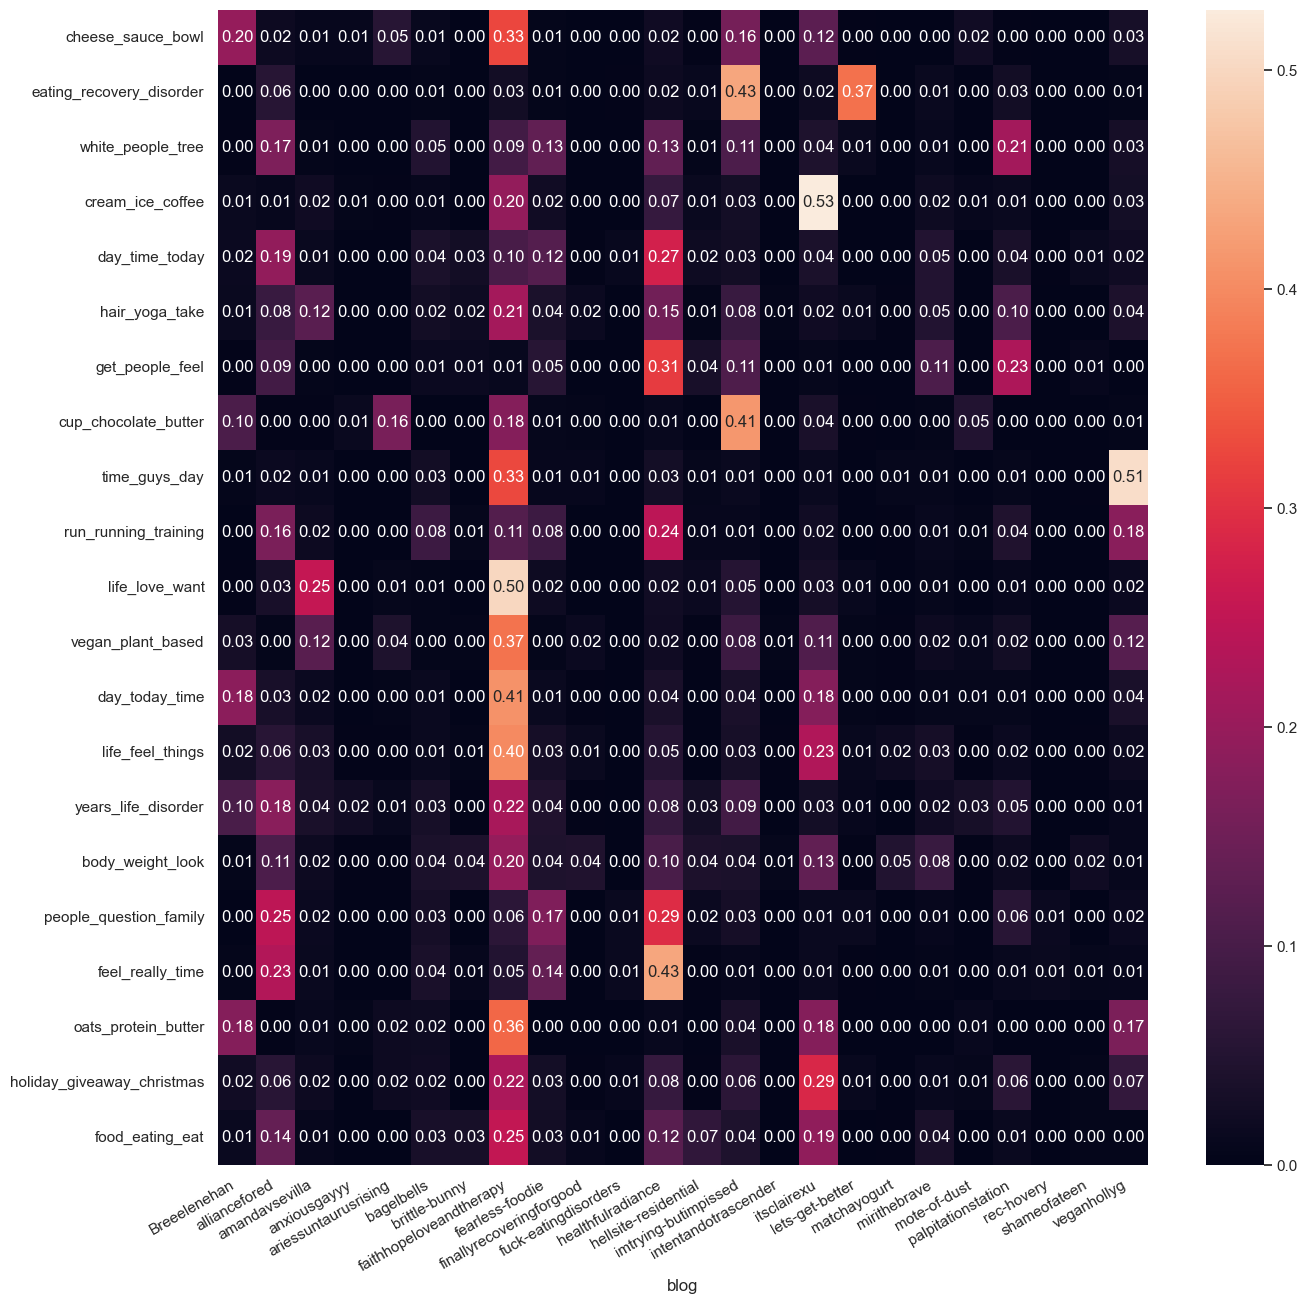

In [58]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(ddist_blog.iloc[:,0:-1].astype('float').T,fmt=".2f",annot=True)

plt.xticks(rotation=30,ha='right') 
plt.savefig('./result/edml/new_old_ed_topics.svg')
# plt.show()

In [33]:
text_df[text_df.id.isin([10491,10596])]

,id,text,original_text,date,url,blog,Topic0_dist,Topic1_dist,Topic2_dist,Topic3_dist,...,Topic11_select,Topic12_select,Topic13_select,Topic14_select,Topic15_select,Topic16_select,Topic17_select,Topic18_select,Topic19_select,Topic20_select
6470,10491,kind sandwich ice cream sandwich cathyscle coo...,My kind of sandwich 😎 // ice cream sandwich fr...,2018-08-28 18:34:30,https://www.instagram.com/p/BnCGVyeALTW/,itsclairexu,0.001684,0.003492,0.898432,0.002312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6567,10596,shoutout pizza_mikeys creative unique pizzas c...,Shoutout to @pizza_mikeys for having the most ...,2018-06-26 17:12:13,https://www.instagram.com/p/Bkfu2BKA_OH/,itsclairexu,0.001952,0.004048,0.882260,0.002680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12785,10596,thelovelynope deal food report hr harassment,thelovelynope: I-I just don't know how to dea...,2020-07-12 12:02:11 GMT,https://hellsite-residential.tumblr.com/post/6...,hellsite-residential,0.003244,0.006726,0.010792,0.004452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
text_df[text_df.id.isin([4335,4872,4125,3120,2425])]


,id,text,original_text,date,url,blog,Topic0_dist,Topic1_dist,Topic2_dist,Topic3_dist,...,Topic4_select,Topic5_select,Topic6_select,Topic7_select,Topic8_select,Topic9_select,Topic10_select,Topic11_select,Topic12_select,Topic13_select
1102,2425,grew entire life allowed certain foods foods e...,I grew up my entire life thinking I'm allowed ...,2022-08-24 10:39:12,https://www.instagram.com/p/Cho522ChBNH/,Breeelenehan,0.000914,0.000158,0.057580,0.001345,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9403,2425,question feel helpful write fictional story su...,Question: I feel like it would be helpful to w...,2021-02-19 18:35:15 GMT,https://faithhopeloveandtherapy.tumblr.com/pos...,faithhopeloveandtherapy,0.984433,0.000388,0.001292,0.003309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9968,3120,time stop process journal tuesday therapy sess...,I haven't had time to stop and process (journa...,2020-09-10 20:02:30 GMT,https://faithhopeloveandtherapy.tumblr.com/pos...,faithhopeloveandtherapy,0.986348,0.000340,0.001133,0.002902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10807,4125,therapy screenshot avoidant attachment gets ph...,Therapy .. // screenshot // avoidant attachme...,2020-02-06 12:52:03 GMT,https://faithhopeloveandtherapy.tumblr.com/pos...,faithhopeloveandtherapy,0.988824,0.000278,0.000927,0.002375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10987,4335,talking shhh terminating therapy coming end th...,Talking about (shhh🤫) terminating therapy As...,2020-01-08 19:18:49 GMT,https://faithhopeloveandtherapy.tumblr.com/pos...,faithhopeloveandtherapy,0.992517,0.000186,0.000621,0.001590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11408,4872,therapy rupture part sorry therapy session acc...,Therapy .. // rupture // part I'm sorry this...,2019-09-14 16:06:09 GMT,https://faithhopeloveandtherapy.tumblr.com/pos...,faithhopeloveandtherapy,0.992363,0.000190,0.000634,0.001623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
import math, datetime
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

dataf_rnorm = robjects.DataFrame(ddist_blog.iloc[:,0:-1])
robjects.r(''' 
library(data.table)
topic.title.tall <- melt(setDT(ddist_blog), id.vars = c("title"), variable.name = "topic")
''')

KeyError: <class 'float'>

In [198]:
from plotnine import ggplot, aes, geom_line,geom_tile, scale_fill_gradient
(
ggplot(ddist_blog.iloc[:,0:-1], aes(x='blog')) +
    # geom_tile(aes(fill = value)) + 
    # geom_text(aes(label = round(value, 2))) +
    scale_fill_gradient(low = "white", high = "red")
    # +theme(text = element_text(size=20),axis.text.x = element_text(angle=45, hjust=1))
)

PlotnineError: "Could not evaluate the 'x' mapping: 'blog' (original error: name 'blog' is not defined)"

In [199]:
ddist_blog

,eating_support_alliance_us,bowl_oats_butter_almond,life_body_feel_like,roasted_#healthy_oil_add,body_like_feel_day,day_time_one_like,cup_chocolate_butter_add,id
blog,,,,,,,,
Breeelenehan,0.004505,0.011943,0.032642,0.002196,0.805447,0.123988,0.006482,1873399
alliancefored,0.901694,0.000727,0.074312,0.0,0.035109,0.021241,0.000715,6127291
amandavsevilla,0.009553,0.019371,0.158634,0.015112,0.018207,0.11161,0.005156,6136628
anxiousgayyy,0.000502,0.0,0.020532,0.000634,0.002199,0.002959,0.0,132541
healthfulradiance,0.009095,0.587512,0.09613,0.699153,0.027373,0.112608,0.944535,14710522
imtrying-butimpissed,0.024045,0.015182,0.285263,0.004865,0.031289,0.040838,0.0,1490061
itsclairexu,0.036686,0.293368,0.30226,0.09059,0.05645,0.139927,0.03727,14539093
veganhollyg,0.013919,0.071898,0.030227,0.187451,0.023927,0.446829,0.005842,12825333
